In [2]:
import time
import tensorflow as tf
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt

Using TensorFlow backend.


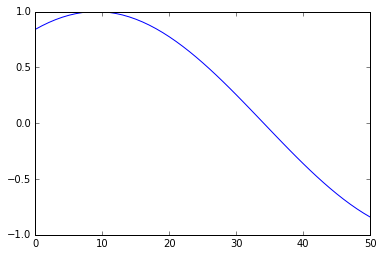

<type 'list'>
[u'-0.967249058', u'-0.98127848', u'-0.991435244', u'-0.997679266', u'-0.999985904', u'-0.998346054', u'-0.992766189', u'-0.983268329', u'-0.969889958', u'-0.952683874', u'-0.931717983', u'-0.907075026', u'-0.878852258', u'-0.847161063', u'-0.812126509', u'-0.773886863', u'-0.73259304', u'-0.688408006', u'-0.64150614', u'-0.592072543', u'-0.540302306', u'-0.486399742', u'-0.430577581', u'-0.373056127', u'-0.314062391', u'-0.253829194', u'-0.192594249', u'-0.130599223', u'-0.068088781', u'-0.005309624', u'0.057490488', u'0.120063711', u'0.182163097', u'0.243543569', u'0.303962886', u'0.3631826', u'0.420968998', u'0.477094024', u'0.531336178', u'0.583481391', u'0.633323869', u'0.680666907', u'0.725323664', u'0.7671179', u'0.805884672', u'0.841470985', u'0.873736397', u'0.90255357', u'0.927808777', u'0.949402346']


In [18]:
f = open("sinwave.csv", 'rb').read()
data = f.decode().split('\n')
# data is a 1D list of 5001 data points from the sine wave

seq_len = 50
# try changing this and seeing its affect on end result
sequence_length = seq_len + 1
result = []
for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])
# for index in range(len(data) - seq_len + 1):
#     result.append(data[index: index + seq_len])
    # here, index: is not a keyword, but the list data is being sliced from index to index + sequence_length

result = np.array(result)
# result is a list of 4950 lists where each sublist is a list of the datapoints in that particular 51 datapoint window
# this shape is 4950 x 51

t = np.linspace(0, 50, 51)
# t = np.linspace(0, 49, 50)
plt.plot(t, result[0])
plt.show()

row = round(0.9 * result.shape[0])
# to split the data set into train and test
# try changing this and seeing its affect on end result

# train = result[:int(row), :]
# train is 4455 x 51
# np.random.shuffle(train)
# try commenting this and seeing its effect on end result
# x_train = train[:, :-1]
# y_train = train[:, -1]
x_train = result[:int(row), :-1]
y_train = result[:int(row), -1]
x_test = result[int(row):, :-1]
y_test = result[int(row):, -1]

print(type(x_test[0].tolist()))
print(x_test[0].tolist())

# print(x_test[0].shape)
# new = x_test[0].tolist()
# print(len(x_test[0]))
# x_test = x_test[newaxis,:,:]
# print(x_test.shape)

# x_train.shape = (4455, 50), and x_test.shape = (495, 50)
# Adding an extra dimension as Keras LSTM layers take in a NumPy array of 3 dimensions: (4455, 50) --> (4455, 50, 1)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [4]:
def build_model(layers):
    # here layers is a list with 4 elements
    
    model = Sequential()
    
    model.add(LSTM(
        input_dim = layers[0],
        output_dim = layers[1],
        return_sequences = True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(
        layers[2],
        return_sequences = False))
    model.add(Dropout(0.2))
    
    model.add(Dense(
        output_dim = layers[3]))
    model.add(Activation("linear"))
    
    model.compile(loss="mse", optimizer="rmsprop")
    
    # try changing whether there is dropout, activation function, loss function, number of layers, in/out of layers
    
    return model

In [5]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    # .predict() is a Keras function for simply running through a given input through the model
    predicted = np.reshape(predicted, (predicted.size,))
    # this simply changes the shape of predicted from (495, 1) to (495, )
    return predicted

def predict_sequence_full(model, data, window_size):
    # Because curr_frame = data[0], the first 50 points are used to predict the entire sequence of 495
    curr_frame = data[0]
    # data here is x_test, which is a list of 495 lists where each list has 50 data points
    # so data[0] is the first list with 50 data points
    # this is 2D despite x_test in its entirety being 3D
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        # the newaxis turns the 2D array into a 3D array to be fed into the model
        # the [0, 0] just extracts the value from the array and appends the value.
        curr_frame = curr_frame[1:]
        # keeps the last 49 numbers of the originally 50 data point list
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        # window_size-1 means that there should be 50 - 1 = 49 indices before the insertion
        # the last predicted value (predicted[-1]) is inserted to curr_frame, making it another 50 data point list,
        # before this new list is run through the model once again int he first line of the for loop
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [13]:
epochs = 1
global_start_time = time.time()

model = build_model([1, 50, 100, 1])

model.fit(x_train,
          y_train,
          batch_size=512,
          nb_epoch=epochs,
          validation_split=0.05)

# predicted = predict_point_by_point(model, x_test)
# t_two = np.linspace(0, 494, 495)
# plt.plot(t_two, predicted)
# plt.show()

# converting y_test to float32 as predictions are in float32
y_test = y_test.astype(np.float32)

predicted = predict_sequence_full(model, x_test, seq_len)
t_two = np.linspace(0, 544, 545)
print(x_test[0])
x_test_zero = x_test[0].tolist()
print(type(x_test_zero[0]))
print(x_test_zero[0])
new = x_test_zero + predicted
# print(len(new))
# print(len(t_two))
# print(type(t_two))
# print(type(new))
print(new[:10])
print(t_two[:10])
# new_flatten = new.flatten()
# print(new_flatten[0:10])
flat_list = [item for sublist in new for item in sublist]
print(flat_list[0:10])
plt.plot(t_two.tolist(), new)
plt.show()
# trying to plot 545 data points where the first 50 are actual points from the original sine wave and the remaining
# 495 are predicted from this original set of 50
# Google / Reddit error.
# x_test's format seems to be different where it was initialized way above and here. Test there then implement here.

# predictions = predict_sequences_multiple(model, x_test, seq_len, 50)

print('Training duration (s) : ', time.time() - global_start_time)
# plot_results_multiple(predictions, y_test, 50)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, return_sequences=True, input_shape=(None, 1))`
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


Train on 4232 samples, validate on 223 samples
Epoch 1/1
4232/4232 [==============================] - 6s 1ms/step - loss: 0.1943 - val_loss: 0.0564
[[u'-0.967249058']
 [u'-0.98127848']
 [u'-0.991435244']
 [u'-0.997679266']
 [u'-0.999985904']
 [u'-0.998346054']
 [u'-0.992766189']
 [u'-0.983268329']
 [u'-0.969889958']
 [u'-0.952683874']
 [u'-0.931717983']
 [u'-0.907075026']
 [u'-0.878852258']
 [u'-0.847161063']
 [u'-0.812126509']
 [u'-0.773886863']
 [u'-0.73259304']
 [u'-0.688408006']
 [u'-0.64150614']
 [u'-0.592072543']
 [u'-0.540302306']
 [u'-0.486399742']
 [u'-0.430577581']
 [u'-0.373056127']
 [u'-0.314062391']
 [u'-0.253829194']
 [u'-0.192594249']
 [u'-0.130599223']
 [u'-0.068088781']
 [u'-0.005309624']
 [u'0.057490488']
 [u'0.120063711']
 [u'0.182163097']
 [u'0.243543569']
 [u'0.303962886']
 [u'0.3631826']
 [u'0.420968998']
 [u'0.477094024']
 [u'0.531336178']
 [u'0.583481391']
 [u'0.633323869']
 [u'0.680666907']
 [u'0.725323664']
 [u'0.7671179']
 [u'0.805884672']
 [u'0.841470985']
 

TypeError: 'numpy.float32' object is not iterable